In [1]:
#! pip install dataretrieval
#! pip install bmipy
import sys 
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe_perturb_ens
import bmi_usgs
from usgs import USGS
import new_bmi_EnKF as bmi_EnKF
import bmi_cfe

In [2]:
usgs_instance = bmi_usgs.BMI_USGS()
enkf_instance = bmi_EnKF.BMIEnKF('./input_enkf_new.json')
cfe_purturb_instance = bmi_cfe_perturb_ens.BMI_CFE('./new_cfe_perturb.json')
cfe_instance = bmi_cfe.BMI_CFE('./new_cfe.json')

In [3]:
#initialization
cfe_purturb_instance.initialize()
cfe_instance.initialize()
enkf_instance.initialize()
usgs_instance.initialize(cfg_file='usgs_config.json', current_time_step=1)

In [4]:
with open(cfe_purturb_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    


cfe_purturb_inputs = cfe_purturb_instance.get_input_var_names()
input_lists_cfe_purturb = {inputs:{ens:[] for ens in range(0)} for inputs in cfe_purturb_inputs}
print("CFE Perturbed code inputs are:", input_lists_cfe_purturb)

cfe_inputs = cfe_instance.get_input_var_names()
input_lists_cfe = {inputs:{ens:[] for ens in range(0)} for inputs in cfe_inputs}
print("CFE code inputs are:", input_lists_cfe)

enkf_inputs = enkf_instance.get_input_var_names()
input_lists_enkf = {inputs:{ens:[] for ens in range(0)} for inputs in enkf_inputs}
print("EnKF code inputs are:", input_lists_enkf)

usgs_inputs = usgs_instance.get_input_var_names()
input_lists_usgs = {inputs:{ens:[] for ens in range(0)} for inputs in usgs_inputs}
print("USGS code inputs are:", input_lists_usgs)


cfe_purturb_outputs = cfe_purturb_instance.get_output_var_names()
output_lists_cfe_purturb = {output:{ens:[] for ens in range(0)} for output in cfe_purturb_outputs}
print("CFE Perturbed code outputs are:", output_lists_cfe_purturb)



cfe_outputs = cfe_instance.get_output_var_names()
output_lists_cfe = {output:{ens:[] for ens in range(0)} for output in cfe_outputs}
print("CFE code outputs are:", output_lists_cfe)

enkf_outputs = enkf_instance.get_output_var_names()
output_lists_enkf = {output:{ens:[] for ens in range(0)} for output in enkf_outputs}
print("EnKF code outputs are:", output_lists_enkf)

usgs_outputs = usgs_instance.get_output_var_names()
output_lists_usgs = {output:{ens:[] for ens in range(0)} for output in usgs_outputs}
print("USGS code outputs are:", output_lists_usgs)


CFE Perturbed code inputs are: {'atmosphere_water__time_integral_of_precipitation_mass_flux': {}, 'water_potential_evaporation_flux': {}}
CFE code inputs are: {'atmosphere_water__time_integral_of_precipitation_mass_flux': {}, 'water_potential_evaporation_flux': {}}
EnKF code inputs are: {'Observations': {}, 'Simulations': {}, 'State Variables': {}}
USGS code inputs are: {'sites': {}, 'start': {}, 'end': {}}
CFE Perturbed code outputs are: {'land_surface_water__runoff_depth': {}, 'land_surface_water__runoff_volume_flux': {}, 'DIRECT_RUNOFF': {}, 'GIUH_RUNOFF': {}, 'NASH_LATERAL_RUNOFF': {}, 'DEEP_GW_TO_CHANNEL_FLUX': {}, 'SOIL_CONCEPTUAL_STORAGE': {}, 'atmosphere_water__time_integral_of_precipitation_mass_flux': {}}
CFE code outputs are: {'land_surface_water__runoff_depth': {}, 'land_surface_water__runoff_volume_flux': {}, 'DIRECT_RUNOFF': {}, 'GIUH_RUNOFF': {}, 'NASH_LATERAL_RUNOFF': {}, 'DEEP_GW_TO_CHANNEL_FLUX': {}, 'SOIL_CONCEPTUAL_STORAGE': {}}
EnKF code outputs are: {'state_estima

In [5]:
cfe_purturb_outputs = cfe_purturb_instance.get_output_var_names()
output_lists_cfe_purturb = {output:{ens:[] for ens in range(cfe_purturb_instance.n_cfe_ensembles)} for output in cfe_outputs}

cfe_outputs = cfe_instance.get_output_var_names()
output_lists_cfe = {output:{ens:[] for ens in range(cfe_purturb_instance.n_cfe_ensembles)} for output in cfe_outputs}

enkf_outputs = enkf_instance.get_output_var_names()
output_lists_enkf = {output:{ens:[] for ens in range(cfe_purturb_instance.n_cfe_ensembles)} for output in enkf_outputs}

usgs_outputs = usgs_instance.get_output_var_names()
output_lists_usgs = {output:{ens:[] for ens in range(cfe_purturb_instance.n_cfe_ensembles)} for output in usgs_outputs}

In [6]:
usgs_instance.update()
Flow = usgs_instance.get_value("Flow")
Flow.shape

(768,)

In [7]:
updated_simulations_all = []
state_variables_all = []
simulations_all = []
observations_all = []
updated_state_all = []

for t, precip in enumerate(df_forcing['APCP_surface']):
    
    cfe_purturb_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_purturb_instance.update()
    
    simulations = cfe_purturb_instance.get_value("land_surface_water__runoff_volume_flux")
    simulations = np.array(list(simulations.values()))
    simulations_all.append(simulations)
    
    state_variables = cfe_purturb_instance.get_value("SOIL_CONCEPTUAL_STORAGE")
    #state_variables = np.array(list(state_variables.values()))
    state_variables_all.append(state_variables)
    usgs_instance.update()
    Flow = usgs_instance.get_value("Flow")[t]
    #Flow = Flow * 0.0283168466 * 3600
    observations_all.append(Flow)
    
    enkf_instance.set_value('Observations', Flow) 
    enkf_instance.set_value('Simulations', simulations)
    enkf_instance.set_value('State Variables', state_variables)
    enkf_instance.update()
    updated_state = enkf_instance.get_value("state_estimates")
    updated_state_all.append(updated_state)
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_instance.set_value('SOIL_CONCEPTUAL_STORAGE', updated_state)
    cfe_instance.update()
    simulation_updated = cfe_instance.get_value("land_surface_water__runoff_volume_flux")
    updated_simulations_all.append(simulation_updated)
    
    nested_states = state_variables[0]
    list_of_states = [nested_states] * 100
    cfe_purturb_instance.set_value('SOIL_CONCEPTUAL_STORAGE', list_of_states)
    #cfe_purturb_instance.finalize()
    

In [8]:
bare_cfe_all = []
for t, precip in enumerate(df_forcing['APCP_surface']):
    cfe_instance.initialize()
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_instance.update()
    CFE = cfe_instance.get_value("land_surface_water__runoff_volume_flux")
    bare_cfe_all.append(CFE)

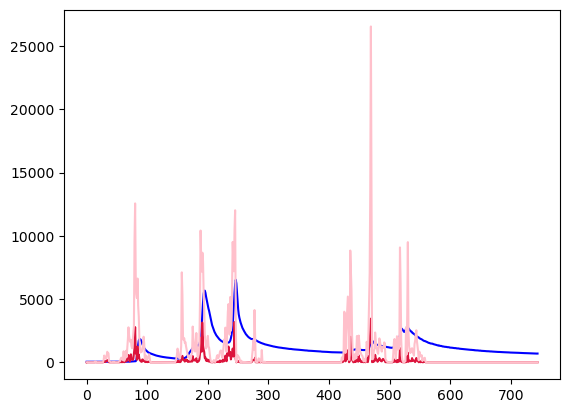

In [9]:
plt.plot(observations_all, color='blue', label='Observations')
#plt.plot(updated_simulations_all, color='green', label='For ourselves')
plt.plot(np.mean(simulations_all, axis = 1), color='crimson', label='DA-CFE')
plt.plot(bare_cfe_all, color='pink', label='CFE')


In [ ]:
np.shape(simulations_all)

In [ ]:
print(simulations_all)

In [ ]:
updated_simulations_all = []
state_variables_all = []
simulations_all = []
observations_all = []
updated_state_all = []

for t, precip in enumerate(df_forcing['APCP_surface']):
    if t == 0:
        nested_states = np.array(10)
        list_of_states = [nested_states] * 100
    
        cfe_purturb_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
        cfe_purturb_instance.set_value('SOIL_CONCEPTUAL_STORAGE', list_of_states)
        cfe_purturb_instance.update()
    
        simulations = cfe_purturb_instance.get_value("land_surface_water__runoff_volume_flux")
        simulations = np.array(list(simulations.values()))
        simulations_all.append(simulations)

In [ ]:
print(np.mean(simulations_all, axis = 0))